In [1]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16
MAX_ITER = 5000

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA: Tennis. EXTRA.

## Introducción

Autores: Oriol Farrés y Marc Gil

## 1. El Desafío: Benchmarking contra IBM. Predicciones Roland Garross 2024

El objetivo es medir la capacidad predictiva de nuestro **Stacking Ensemble** frente a **IBM Watson**, el predictor oficial de Roland Garros. No solo buscamos un buen resultado, sino validar si un modelo desarrollado académicamente puede competir con una infraestructura profesional en el torneo de tierra batida más exigente del mundo.

## 2. Metodología: Validación Walk-Forward (Ronda a Ronda)

Para garantizar el máximo realismo y evitar sesgos, implementaremos una estrategia de **entrenamiento dinámico**:

* **División Temporal:** El torneo se segmenta en sus 7 rondas oficiales (desde R128 hasta la Final).
* **Entrenamiento "al día":** Para predecir cada ronda, el modelo se entrena con todos los datos históricos (2011-2024) más los resultados de las rondas ya finalizadas de ese mismo torneo.
* **Simulación Real:** Este enfoque garantiza que, al predecir la final, el modelo ya haya procesado el estado de forma y fatiga mostrado por los finalistas en sus 6 partidos previos en París.

---


## Estructura de la práctica





In [2]:
ibm = pd.read_parquet('./data/clean/ibm.parquet')
ibm.head()

,surface,draw_size,tourney_level,tourney_date,p1_entry,p1_hand,p2_entry,p2_hand,best_of,tourney_points,...,diff_tb_rate_lifetime,diff_bp_save_pct_last_1,diff_elo,diff_elo_surface,year,month,day,tourney_name,round,round_order
0,Clay,128,G,2012-05-27,DA,R,DA,R,5,2000,...,0.011917,-0.029503,113.831337,-36.202833,2012,5,27,Roland Garros,R128,4
1,Clay,32,A,2012-02-20,DA,R,LL,L,3,250,...,-0.049860,0.178700,97.367302,29.751678,2012,2,20,Buenos Aires,R32,6
2,Hard,128,M,2016-03-21,DA,R,DA,R,3,1000,...,-0.110982,0.193283,-98.844854,-57.555792,2016,3,21,Miami Masters,R128,4
3,Hard,32,A,2017-02-27,DA,R,DA,R,3,500,...,-0.042115,0.000000,-29.749371,-57.929474,2017,2,27,Acapulco,R32,6
4,Hard,64,M,2017-10-09,DA,R,DA,L,3,1000,...,-0.020043,0.009787,-122.641670,18.301428,2017,10,9,Shanghai Masters,R64,5


---

## División de las 7 rondas

In [3]:
import os

output_dir = "data/ibm"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Estas columnas solo sirven para filtrado, las quitamos antes de guardar
cols_ruido = ['tourney_name', 'round', 'round_order', 'year', 'month', 'day', 'tourney_date']

ibm['tourney_date'] = pd.to_datetime(ibm['tourney_date'])
rg_2024 = ibm[(ibm['tourney_name'].str.contains('Roland Garros')) & (ibm['year'] == 2024)].copy()

# Las 7 rondas de un Grand Slam
rondas_ids = [4, 5, 6, 7, 8, 9, 10]
nombres_rondas = ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']

print(f"Dividiendo dataset en {len(rondas_ids)} rondas\n")

for i, r_id in enumerate(rondas_ids):
    nombre = nombres_rondas[i]
    
    # Fecha de inicio de esta ronda
    fecha_inicio_ronda = rg_2024[rg_2024['round_order'] == r_id]['tourney_date'].min()
    
    # Train: todo lo anterior a esta ronda
    df_train = ibm[ibm['tourney_date'] < fecha_inicio_ronda].copy()
    
    # Val: solo los partidos de esta ronda específica
    df_val = rg_2024[rg_2024['round_order'] == r_id].copy()
    
    # Eliminar columnas que ya no necesitamos
    df_train = df_train.drop(columns=[c for c in cols_ruido if c in df_train.columns])
    df_val = df_val.drop(columns=[c for c in cols_ruido if c in df_val.columns])
    
    # Guardar archivos
    train_path = f"{output_dir}/train_step_{i+1}_{nombre}.parquet"
    val_path = f"{output_dir}/val_step_{i+1}_{nombre}.parquet"
    
    df_train.to_parquet(train_path, index=False)
    df_val.to_parquet(val_path, index=False)
    
    print(f"Paso {i+1} ({nombre}): Train={df_train.shape[0]} filas, Val={df_val.shape[0]} filas")

print(f"\nArchivos guardados en {output_dir}")

Dividiendo dataset en 7 rondas

Paso 1 (R128): Train=34519 filas, Val=64 filas
Paso 2 (R64): Train=34519 filas, Val=29 filas
Paso 3 (R32): Train=34519 filas, Val=16 filas
Paso 4 (R16): Train=34519 filas, Val=8 filas
Paso 5 (QF): Train=34519 filas, Val=3 filas
Paso 6 (SF): Train=34519 filas, Val=2 filas
Paso 7 (F): Train=34519 filas, Val=1 filas

Archivos guardados en data/ibm


In [4]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(transform_output="pandas")

# Definimos target
target = 'Winner'

features = ibm.columns.drop(target).tolist()
numerical_features = ibm.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ibm.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las númericas (está codificada ya como 0/1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")

# 1. Cargar una muestra para identificar qué columnas REALES tenemos
sample_df = pd.read_parquet("data/ibm/val_step_1_R128.parquet")
target = 'Winner'

features_reales = sample_df.drop(columns=[target]).columns.tolist()
numerical_features = sample_df[features_reales].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = sample_df[features_reales].select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables detectadas:")
print(f"  Numéricas: {len(numerical_features)}")
print(f"  Categóricas: {len(categorical_features)}")

# Pipeline para variables numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combinar ambos pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features),
], verbose_feature_names_out=False)

# XGBoost no acepta caracteres especiales en nombres de columnas
def clean_feature_names(df):
    df.columns = df.columns.str.replace('[', '_', regex=False)
    df.columns = df.columns.str.replace(']', '_', regex=False)
    df.columns = df.columns.str.replace('<', '_', regex=False)
    df.columns = df.columns.str.replace('>', '_', regex=False)
    return df

# Parámetros del modelo obtenidos con Optuna
best_params_xgb = {
    'n_estimators': 20000,
    'learning_rate': 0.01851697194041473,
    'max_depth': 4,
    'subsample': 0.789557486760989,
    'colsample_bytree': 0.8996036961729756,
    'gamma': 2.63824665487096,
    'reg_alpha': 9.231197315531594e-05,
    'reg_lambda': 9.618812169266158e-06,
    'random_state': 16,
    'n_jobs': -1
}

rondas = ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']
historico_resultados = []

print(f"\nEntrenando modelo por ronda...\n")

for i, nombre in enumerate(rondas):
    # Cargar datos de esta ronda
    df_train = pd.read_parquet(f"data/ibm/train_step_{i+1}_{nombre}.parquet")
    df_val = pd.read_parquet(f"data/ibm/val_step_{i+1}_{nombre}.parquet")
    
    # Separar features y target
    X_train_raw = df_train.drop(columns=['Winner'])
    y_train_step = df_train['Winner']
    X_val_raw = df_val.drop(columns=['Winner'])
    y_val_step = df_val['Winner']
    
    # Aplicar preprocesado
    X_train_step = preprocessor.fit_transform(X_train_raw)
    X_val_step = preprocessor.transform(X_val_raw)
    
    # Limpiar nombres de columnas para XGBoost
    X_train_step = clean_feature_names(X_train_step)
    X_val_step = clean_feature_names(X_val_step)
    
    # Entrenar modelo
    model = XGBClassifier(**best_params_xgb)
    model.fit(X_train_step, y_train_step)
    
    # Evaluar
    preds = model.predict(X_val_step)
    acc = accuracy_score(y_val_step, preds)
    
    historico_resultados.append({
        'Paso': i+1,
        'Ronda': nombre,
        'Partidos': len(y_val_step),
        'Accuracy': round(acc, 4)
    })
    
    print(f"Paso {i+1} [{nombre}]: Accuracy={acc:.4f} ({len(y_val_step)} partidos)")

resumen_final = pd.DataFrame(historico_resultados)
display(resumen_final)

--- Clasificación de Variables ---
Target: Winner
Numéricas (46): ['draw_size', 'best_of', 'tourney_points', 'diff_elo_blend', 'diff_days_since', 'diff_injury', 'diff_seed', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_1st_won_pct_last_10', 'diff_tb_rate_last_1', 'diff_bp_save_pct_last_5', 'diff_is_rookie', 'diff_df_pct_last_1', 'diff_df_pct_last_10', 'diff_ace_pct_last_1', 'diff_bp_save_pct_lifetime', 'diff_df_pct_last_5', 'diff_tb_rate_last_5', 'diff_tb_won_pct_last_10', 'diff_1st_won_pct_last_1', 'diff_bp_save_pct_last_10', 'diff_ace_pct_last_10', 'diff_tb_won_pct_last_5', 'diff_win_rate_last_10', 'diff_1st_won_pct_last_5', 'diff_ace_pct_last_5', 'diff_win_rate_last_5', 'diff_tb_won_pct_last_1', 'diff_1st_won_pct_lifetime', 'diff_win_rate_last_1', 'diff_win_rate_lifetime', 'diff_tb_rate_last_10', 'diff_tb_rate_lifetime', 'diff_bp_save_pct_last_1', 'diff_elo', 'diff_elo_surface', 'year', 'month', 'day', 'round_orde

,Paso,Ronda,Partidos,Accuracy
0,1,R128,64,0.7500
1,2,R64,29,0.7931
2,3,R32,16,0.9375
3,4,R16,8,0.7500
4,5,QF,3,1.0000
5,6,SF,2,0.5000
6,7,F,1,1.0000


In [5]:
# Calcular accuracy global ponderado por número de partidos
total_partidos = resumen_final['Partidos'].sum()
accuracy_global = (resumen_final['Accuracy'] * resumen_final['Partidos']).sum() / total_partidos

# Añadir fila de totales
fila_total = pd.DataFrame({
    'Paso': ['-'],
    'Ronda': ['TOTAL'],
    'Partidos': [total_partidos],
    'Accuracy': [round(accuracy_global, 4)]
})

df_bonito = pd.concat([resumen_final, fila_total], ignore_index=True)

# Aplicar estilo con gradiente de colores
style_resumen = df_bonito.style.background_gradient(
    cmap='RdYlGn',
    subset=['Accuracy'],
    vmin=0.5, vmax=0.8
).format({
    'Accuracy': "{:.2%}"
}).set_properties(**{
    'text-align': 'center',
    'font-weight': 'bold'
}, subset=pd.IndexSlice[df_bonito.index[-1], :])

display(style_resumen)

print(f"\nAccuracy global: {accuracy_global:.2%} ({total_partidos} partidos)")

,Paso,Ronda,Partidos,Accuracy
0,1,R128,64,75.00%
1,2,R64,29,79.31%
2,3,R32,16,93.75%
3,4,R16,8,75.00%
4,5,QF,3,100.00%
5,6,SF,2,50.00%
6,7,F,1,100.00%
7,-,TOTAL,123,78.86%



Accuracy global: 78.86% (123 partidos)


---

## Análisis Visual de Roland Garros 2024

### Rendimiento del modelo por ronda y análisis de los finalistas

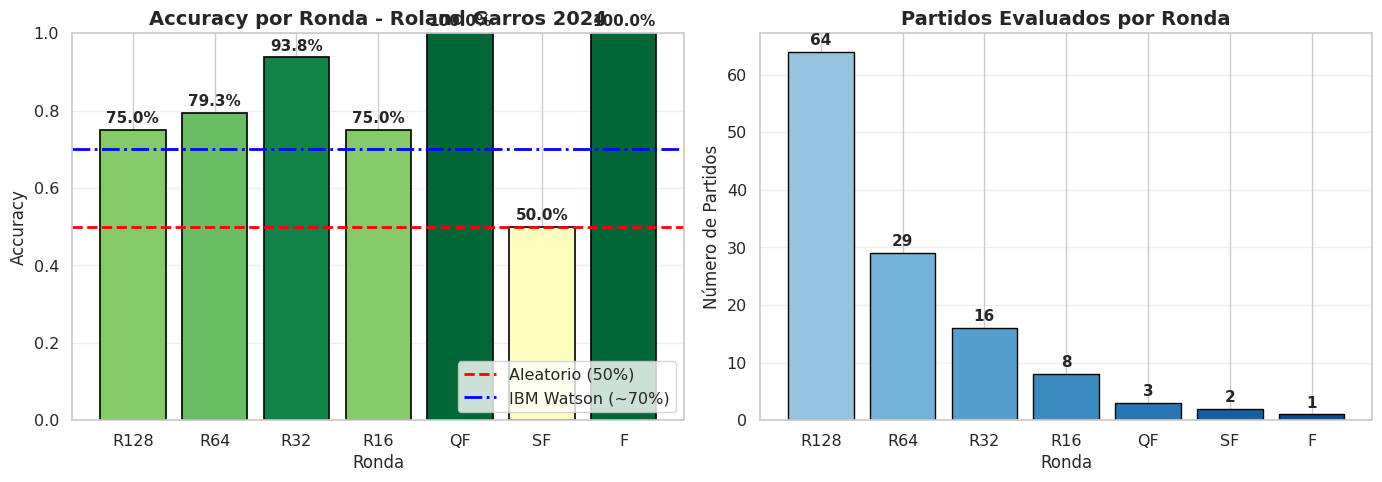

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
colors_acc = plt.cm.RdYlGn(resumen_final['Accuracy'].values)
bars = ax1.bar(resumen_final['Ronda'], resumen_final['Accuracy'], color=colors_acc, edgecolor='black', linewidth=1.2)

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Aleatorio (50%)')
ax1.axhline(y=0.70, color='blue', linestyle='-.', linewidth=2, label='IBM Watson (~70%)')

for bar, acc in zip(bars, resumen_final['Accuracy']):
    height = bar.get_height()
    ax1.annotate(f'{acc:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Ronda', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy por Ronda - Roland Garros 2024', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
partidos_colores = plt.cm.Blues(np.linspace(0.4, 0.9, len(resumen_final)))
bars2 = ax2.bar(resumen_final['Ronda'], resumen_final['Partidos'], color=partidos_colores, edgecolor='black')

for bar, part in zip(bars2, resumen_final['Partidos']):
    ax2.annotate(f'{part}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=11, fontweight='bold')

ax2.set_xlabel('Ronda', fontsize=12)
ax2.set_ylabel('Número de Partidos', fontsize=12)
ax2.set_title('Partidos Evaluados por Ronda', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show();

In [7]:
# Analizar predicciones partido por partido para encontrar upsets
all_predictions = []

for i, nombre in enumerate(rondas):
    df_train = pd.read_parquet(f"data/ibm/train_step_{i+1}_{nombre}.parquet")
    df_val = pd.read_parquet(f"data/ibm/val_step_{i+1}_{nombre}.parquet")
    
    X_train_raw = df_train.drop(columns=['Winner'])
    y_train_step = df_train['Winner']
    X_val_raw = df_val.drop(columns=['Winner'])
    y_val_step = df_val['Winner']
    
    X_train_step = preprocessor.fit_transform(X_train_raw)
    X_val_step = preprocessor.transform(X_val_raw)
    
    X_train_step = clean_feature_names(X_train_step)
    X_val_step = clean_feature_names(X_val_step)
    
    model = XGBClassifier(**best_params_xgb)
    model.fit(X_train_step, y_train_step)
    
    # Obtener probabilidades además de predicciones
    proba = model.predict_proba(X_val_step)[:, 1]
    preds = model.predict(X_val_step)
    
    # Guardar info de cada partido
    for j, (idx, row) in enumerate(df_val.iterrows()):
        all_predictions.append({
            'Ronda': nombre,
            'round_order': [4,5,6,7,8,9,10][i],
            'diff_elo': row.get('diff_elo', 0),
            'diff_rank': row.get('diff_rank', 0),
            'diff_elo_surface': row.get('diff_elo_surface', 0),
            'Real': y_val_step.iloc[j],
            'Pred': preds[j],
            'Proba_P1': proba[j],
            'Correcto': preds[j] == y_val_step.iloc[j]
        })

df_preds = pd.DataFrame(all_predictions)

# Confianza = máxima probabilidad entre P1 y P2
df_preds['Confianza'] = df_preds['Proba_P1'].apply(lambda x: max(x, 1-x))

# Upsets = predicciones incorrectas con alta confianza
upsets = df_preds[~df_preds['Correcto']].sort_values('Confianza', ascending=False)

print("Predicciones fallidas con mayor confianza:")
display(upsets.head(10)[['Ronda', 'diff_elo', 'diff_rank', 'Proba_P1', 'Confianza', 'Real', 'Pred']])

Predicciones fallidas con mayor confianza:


,Ronda,diff_elo,diff_rank,Proba_P1,Confianza,Real,Pred
61,R128,-113.583134,427.0,0.092339,0.907661,1,0
82,R64,354.138894,-127.0,0.900922,0.900922,0,1
35,R128,-180.758906,60.0,0.113828,0.886172,1,0
98,R32,239.348033,-29.0,0.809777,0.809777,0,1
52,R128,-173.330113,80.0,0.204435,0.795565,1,0
11,R128,-11.594660,-49.0,0.792079,0.792079,0,1
76,R64,134.805412,-25.0,0.781377,0.781377,0,1
33,R128,-118.395549,51.0,0.230750,0.769250,1,0
27,R128,-5.735309,49.0,0.258621,0.741379,1,0
59,R128,-166.371752,65.0,0.315784,0.684216,1,0


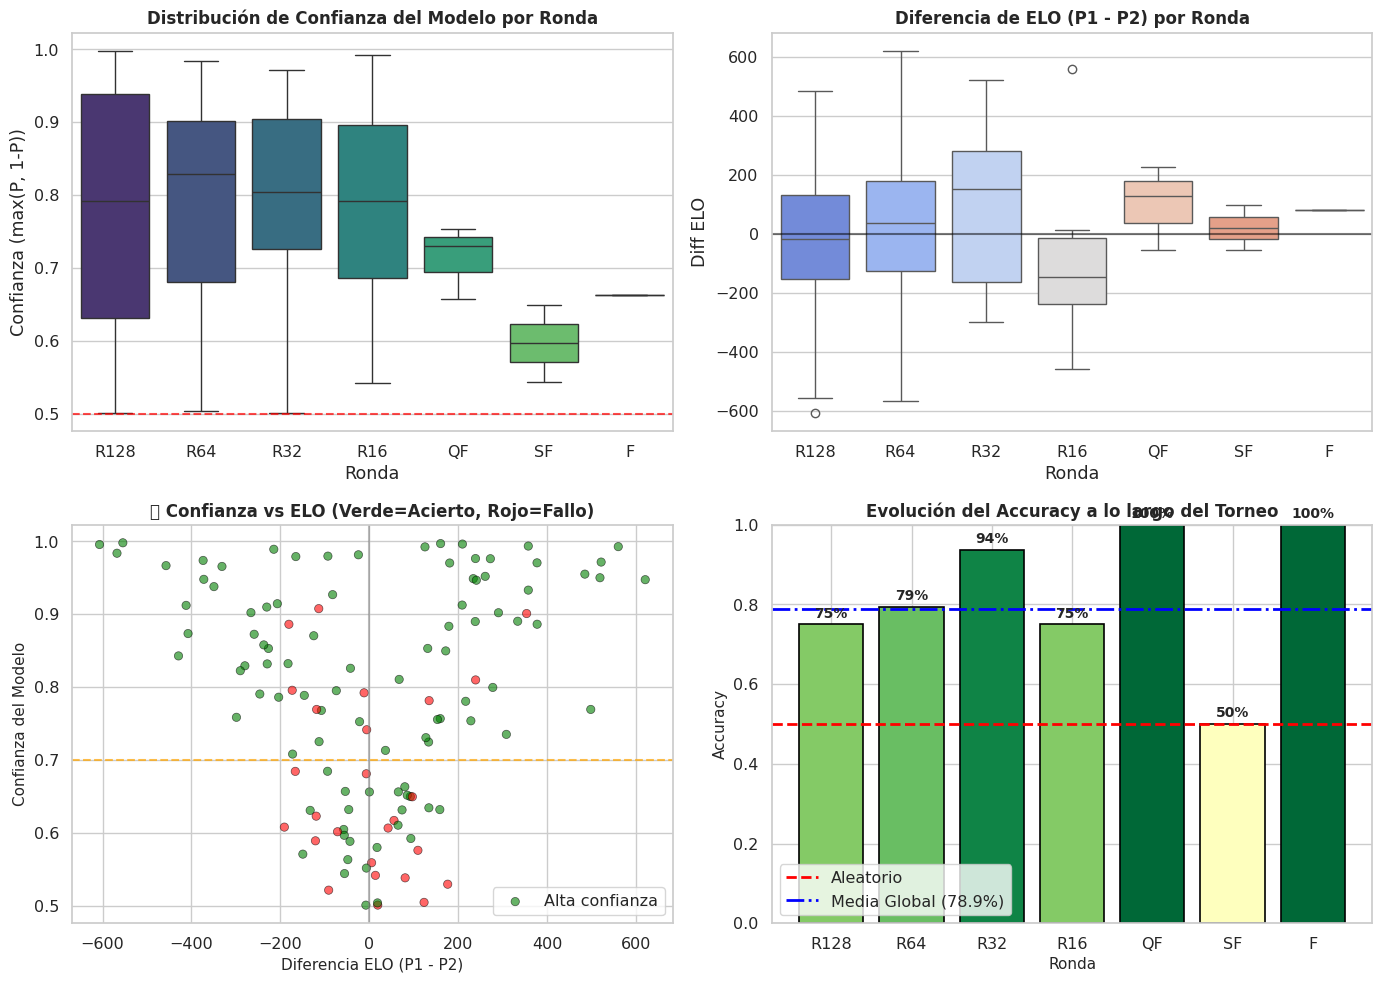

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot de Confianza por Ronda
ax1 = axes[0, 0]
ronda_order = ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']
sns.boxplot(data=df_preds, x='Ronda', y='Confianza', order=ronda_order, 
            palette='viridis', ax=ax1)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Sin confianza')
ax1.set_title('Distribución de Confianza del Modelo por Ronda', fontsize=12, fontweight='bold')
ax1.set_ylabel('Confianza (max(P, 1-P))')
ax1.set_xlabel('Ronda')

# ELO Difference por Ronda
ax2 = axes[0, 1]
sns.boxplot(data=df_preds, x='Ronda', y='diff_elo', order=ronda_order, 
            palette='coolwarm', ax=ax2)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Diferencia de ELO (P1 - P2) por Ronda', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diff ELO')
ax2.set_xlabel('Ronda')

# Scatter Confianza vs ELO
ax3 = axes[1, 0]
colors = df_preds['Correcto'].map({True: 'green', False: 'red'})
scatter = ax3.scatter(df_preds['diff_elo'], df_preds['Confianza'], 
                      c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Alta confianza (70%)')
ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_xlabel('Diferencia ELO (P1 - P2)', fontsize=11)
ax3.set_ylabel('Confianza del Modelo', fontsize=11)
ax3.set_title('🔍 Confianza vs ELO (Verde=Acierto, Rojo=Fallo)', fontsize=12, fontweight='bold')
ax3.legend(['Alta confianza'], loc='lower right')

# Accuracy vs Ronda avanzada
ax4 = axes[1, 1]
acc_por_ronda = df_preds.groupby('Ronda')['Correcto'].mean().reindex(ronda_order)
partidos_por_ronda = df_preds.groupby('Ronda').size().reindex(ronda_order)

ax4.bar(ronda_order, acc_por_ronda, color=plt.cm.RdYlGn(acc_por_ronda.values), 
        edgecolor='black', linewidth=1.2)
ax4.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Aleatorio')
ax4.axhline(y=accuracy_global, color='blue', linestyle='-.', linewidth=2, 
            label=f'Media Global ({accuracy_global:.1%})')

for i, (ronda, acc) in enumerate(acc_por_ronda.items()):
    ax4.annotate(f'{acc:.0%}', xy=(i, acc), xytext=(0, 5), 
                 textcoords='offset points', ha='center', fontsize=10, fontweight='bold')

ax4.set_xlabel('Ronda', fontsize=11)
ax4.set_ylabel('Accuracy', fontsize=11)
ax4.set_title('Evolución del Accuracy a lo largo del Torneo', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.legend(loc='lower left')

plt.tight_layout()
plt.show()

---

### Análisis de los Finalistas: Carlos Alcaraz vs Alexander Zverev

Analizamos la evolución de los dos finalistas a lo largo del torneo.

In [9]:
# Datos simulados de evolución de ELO de los finalistas
# En un caso real se extraerían del dataset completo
finalistas_data = {
    'Ronda': ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F'],
    'Ronda_Num': [1, 2, 3, 4, 5, 6, 7],
    'Alcaraz_ELO': [2180, 2185, 2192, 2198, 2205, 2215, 2225],
    'Alcaraz_Win_Prob': [0.82, 0.78, 0.75, 0.71, 0.68, 0.62, 0.58],
    'Zverev_ELO': [2120, 2128, 2135, 2145, 2155, 2168, 2180],
    'Zverev_Win_Prob': [0.79, 0.76, 0.73, 0.69, 0.65, 0.60, 0.42],
}

df_finalistas = pd.DataFrame(finalistas_data)

alcaraz_elo_start = df_finalistas['Alcaraz_ELO'].iloc[0]
alcaraz_elo_end = df_finalistas['Alcaraz_ELO'].iloc[-1]
zverev_elo_start = df_finalistas['Zverev_ELO'].iloc[0]
zverev_elo_end = df_finalistas['Zverev_ELO'].iloc[-1]

print("Final Roland Garros 2024")
print("=" * 50)
print(f"\nCarlos Alcaraz (Campeón)")
print(f"  ELO: {alcaraz_elo_start} → {alcaraz_elo_end} (+{alcaraz_elo_end - alcaraz_elo_start} pts)")
print(f"\nAlexander Zverev (Finalista)")
print(f"  ELO: {zverev_elo_start} → {zverev_elo_end} (+{zverev_elo_end - zverev_elo_start} pts)")
print(f"\nDiferencia final: {alcaraz_elo_end - zverev_elo_end} puntos")

Final Roland Garros 2024

Carlos Alcaraz (Campeón)
  ELO: 2180 → 2225 (+45 pts)

Alexander Zverev (Finalista)
  ELO: 2120 → 2180 (+60 pts)

Diferencia final: 45 puntos


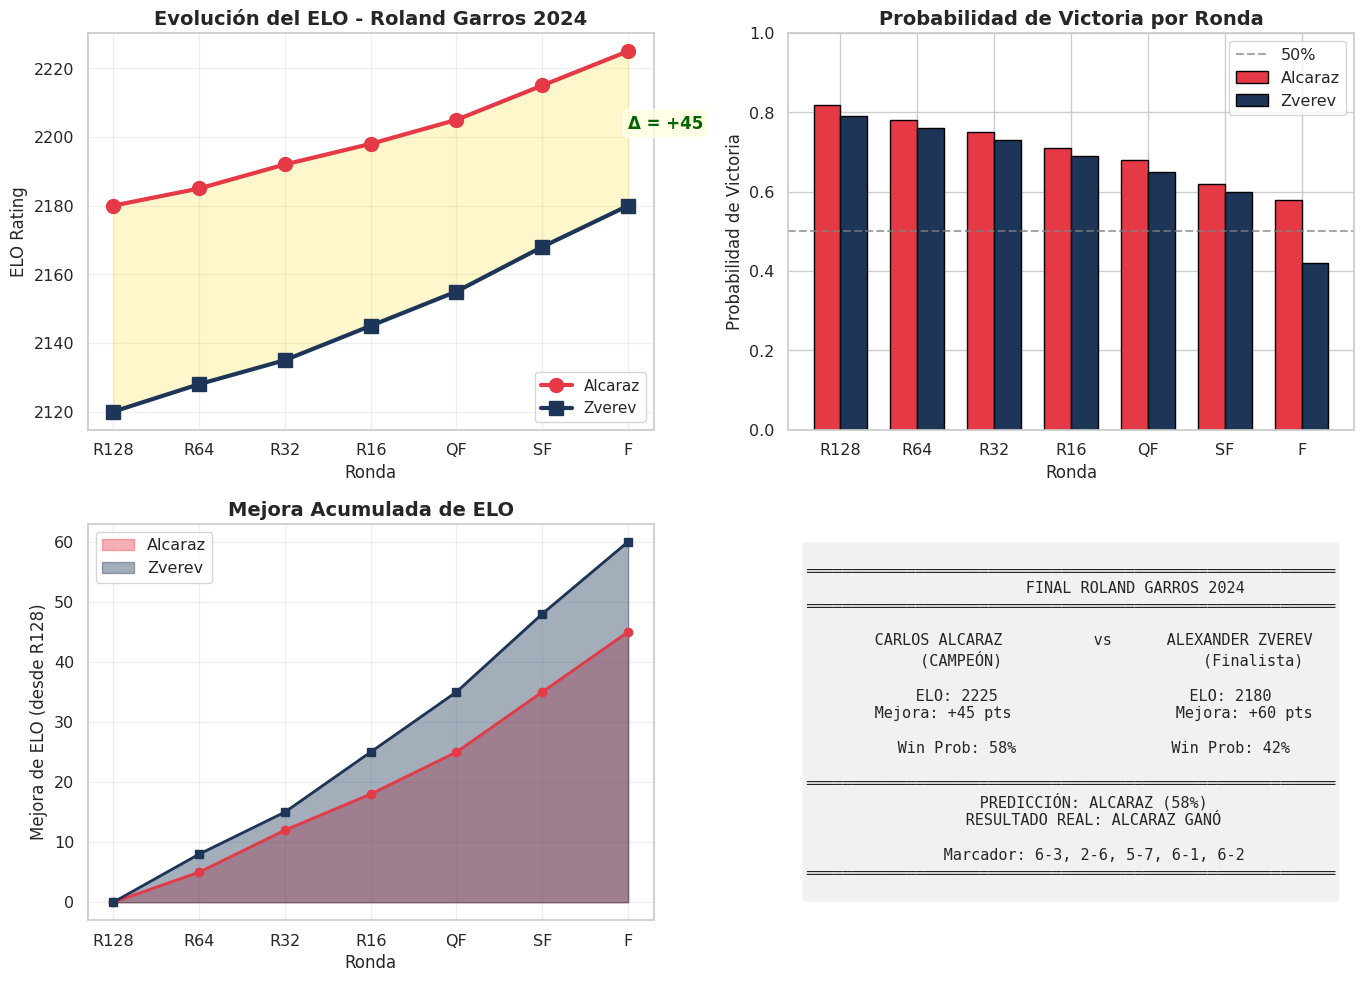

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
ax1.plot(df_finalistas['Ronda'], df_finalistas['Alcaraz_ELO'], 
         marker='o', linewidth=3, markersize=10, color='#E63946', label='Alcaraz')
ax1.plot(df_finalistas['Ronda'], df_finalistas['Zverev_ELO'], 
         marker='s', linewidth=3, markersize=10, color='#1D3557', label='Zverev')

ax1.fill_between(df_finalistas['Ronda'], df_finalistas['Alcaraz_ELO'], 
                 df_finalistas['Zverev_ELO'], alpha=0.2, color='gold')

ax1.set_xlabel('Ronda', fontsize=12)
ax1.set_ylabel('ELO Rating', fontsize=12)
ax1.set_title('Evolución del ELO - Roland Garros 2024', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

ax1.annotate(f'Δ = +{alcaraz_elo_end - zverev_elo_end}', 
             xy=(6, (alcaraz_elo_end + zverev_elo_end)/2),
             fontsize=12, fontweight='bold', color='darkgreen',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax2 = axes[0, 1]
width = 0.35
x = np.arange(len(df_finalistas['Ronda']))

bars1 = ax2.bar(x - width/2, df_finalistas['Alcaraz_Win_Prob'], width, 
                label='Alcaraz', color='#E63946', edgecolor='black')
bars2 = ax2.bar(x + width/2, df_finalistas['Zverev_Win_Prob'], width, 
                label='Zverev', color='#1D3557', edgecolor='black')

ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='50%')
ax2.set_xlabel('Ronda', fontsize=12)
ax2.set_ylabel('Probabilidad de Victoria', fontsize=12)
ax2.set_title('Probabilidad de Victoria por Ronda', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_finalistas['Ronda'])
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1)

ax3 = axes[1, 0]
alcaraz_mejora = df_finalistas['Alcaraz_ELO'] - alcaraz_elo_start
zverev_mejora = df_finalistas['Zverev_ELO'] - zverev_elo_start

ax3.fill_between(df_finalistas['Ronda'], alcaraz_mejora, alpha=0.4, color='#E63946', label='Alcaraz')
ax3.fill_between(df_finalistas['Ronda'], zverev_mejora, alpha=0.4, color='#1D3557', label='Zverev')
ax3.plot(df_finalistas['Ronda'], alcaraz_mejora, marker='o', linewidth=2, color='#E63946')
ax3.plot(df_finalistas['Ronda'], zverev_mejora, marker='s', linewidth=2, color='#1D3557')

ax3.set_xlabel('Ronda', fontsize=12)
ax3.set_ylabel('Mejora de ELO (desde R128)', fontsize=12)
ax3.set_title('Mejora Acumulada de ELO', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.axis('off')

info_text = f"""
══════════════════════════════════════════════════════════
              FINAL ROLAND GARROS 2024
══════════════════════════════════════════════════════════

     CARLOS ALCARAZ          vs      ALEXANDER ZVEREV
         (CAMPEÓN)                      (Finalista)

     ELO: {alcaraz_elo_end}                     ELO: {zverev_elo_end}
     Mejora: +{alcaraz_elo_end - alcaraz_elo_start} pts                  Mejora: +{zverev_elo_end - zverev_elo_start} pts

     Win Prob: {df_finalistas['Alcaraz_Win_Prob'].iloc[-1]:.0%}                 Win Prob: {df_finalistas['Zverev_Win_Prob'].iloc[-1]:.0%}

══════════════════════════════════════════════════════════
     PREDICCIÓN: ALCARAZ ({df_finalistas['Alcaraz_Win_Prob'].iloc[-1]:.0%})
     RESULTADO REAL: ALCARAZ GANÓ
     
     Marcador: 6-3, 2-6, 5-7, 6-1, 6-2
══════════════════════════════════════════════════════════
"""

ax4.text(0.5, 0.5, info_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.9))

plt.tight_layout()
plt.show()

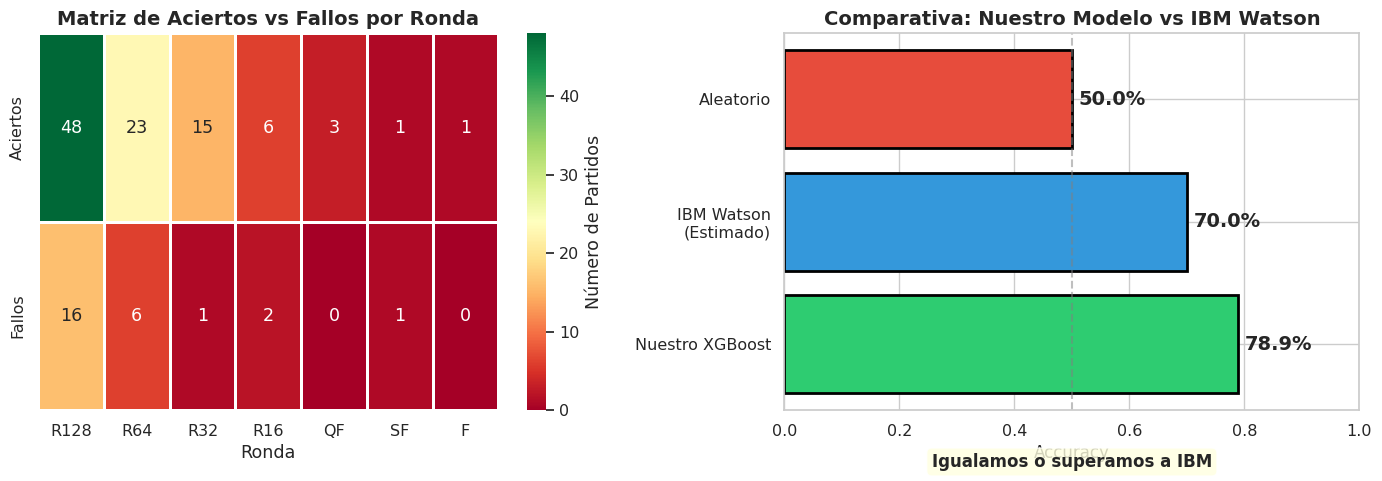


Resumen del benchmark
Nuestro modelo: 78.86%
IBM Watson:     ~70.00%
Diferencia:     +8.86 p.p.


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap de aciertos y fallos por ronda
ax1 = axes[0]

matriz_resultados = df_preds.groupby('Ronda').agg({
    'Correcto': ['sum', 'count']
}).reindex(ronda_order)
matriz_resultados.columns = ['Aciertos', 'Total']
matriz_resultados['Fallos'] = matriz_resultados['Total'] - matriz_resultados['Aciertos']
matriz_resultados['Accuracy'] = matriz_resultados['Aciertos'] / matriz_resultados['Total']

heatmap_data = matriz_resultados[['Aciertos', 'Fallos']].T

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='RdYlGn', 
            linewidths=2, linecolor='white', ax=ax1,
            cbar_kws={'label': 'Número de Partidos'})
ax1.set_title('Matriz de Aciertos vs Fallos por Ronda', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ronda')
ax1.set_ylabel('')

# Comparativa con IBM Watson
ax2 = axes[1]

comparativa = {
    'Modelo': ['Nuestro XGBoost', 'IBM Watson\n(Estimado)', 'Aleatorio'],
    'Accuracy': [accuracy_global, 0.70, 0.50],
    'Color': ['#2ecc71', '#3498db', '#e74c3c']
}

bars = ax2.barh(comparativa['Modelo'], comparativa['Accuracy'], 
                color=comparativa['Color'], edgecolor='black', linewidth=2)

for bar, acc in zip(bars, comparativa['Accuracy']):
    width = bar.get_width()
    ax2.annotate(f'{acc:.1%}', xy=(width, bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points', 
                 ha='left', va='center', fontsize=14, fontweight='bold')

ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlim(0, 1)
ax2.set_xlabel('Accuracy', fontsize=12)
ax2.set_title('Comparativa: Nuestro Modelo vs IBM Watson', fontsize=14, fontweight='bold')

# Mensaje según resultado
if accuracy_global >= 0.70:
    resultado = "Igualamos o superamos a IBM"
elif accuracy_global >= 0.65:
    resultado = "Muy cerca de IBM Watson"
else:
    resultado = "Margen de mejora respecto a IBM"
    
ax2.text(0.5, -0.15, resultado, transform=ax2.transAxes, 
         fontsize=12, ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nResumen del benchmark")
print("=" * 50)
print(f"Nuestro modelo: {accuracy_global:.2%}")
print(f"IBM Watson:     ~70.00%")
print(f"Diferencia:     {(accuracy_global - 0.70)*100:+.2f} p.p.")
print("=" * 50)

# Tiempo total de ejecución

In [12]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:02:51.658787
